### Imports

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import copy

%matplotlib inline
import time

try:
    import mlrose_hiive as mlrh
except:
     !pip install mlrose-hiive



### Four peaks problem

In [52]:
# ----- visualizing the 4 peaks problem -----------
values = []

def evaluate(t_pct, state):
        _n = len(state)
        _t = np.ceil(t_pct*_n)
        tail_0 = tail(0, state)
        head_1 = head(1, state)
        
        if (tail_0 > _t and head_1 > _t):
            _r = _n
        else:
            _r = 0
        fitness = max(tail_0, head_1) + _r
        return fitness
    

def head(_b, _x):
    _head = 0
    for i in _x:
        if i == _b:
            _head += 1
        else:
            break

    return _head


def tail(_b, _x):
    _tail = 0
    for i in range(len(_x)):
        if _x[len(_x) - i - 1] == _b:
            _tail += 1
        else:
            break

    return _tail


x = [i for i in product(range(2), repeat=20)]
x = np.array(x)

for i in x:
    val = evaluate(0.1, i)
    values.append(val)

plt.figure(figsize=(18, 8), dpi=80)
plt.plot(values)
plt.xticks(np.arange(len(x)), x)
plt.show()

KeyboardInterrupt: 

### Applying RHC,SA, GA and mimic to 4 peaks

#### All four algorithms

In [111]:
def sim_ann(problem, fitness, schedule, traintimes, max_values, function_evals, init_state):
    s = time.time()
    best_state, best_fitness, sa_curve = mlrh.simulated_annealing(problem, schedule = schedule,
                                                          max_attempts = 10,
                                                          init_state = init_state, random_state = 1, curve=True)
    e= time.time()
    traintime = e - s
    traintimes['sa'] = traintime
    max_values['sa'] = best_fitness
    function_evals['sa'] = sa_curve[-1, 1]
    return sa_curve, traintimes, max_values, function_evals
    
def rhc_mine(problem, fitness, rs, init_state,traintimes, max_values, function_evals):
    s = time.time()
    best_state, best_fitness, curve = mlrh.random_hill_climb(problem, restarts = rs,
                                                          max_attempts = 10,
                                                          init_state = init_state, random_state = 1, curve=True)
    e= time.time()
    traintime = e - s
    traintimes['rhc'] = traintime
    max_values['rhc'] = best_fitness
    function_evals['rhc'] = curve[-1, 1]
    return curve, traintimes, max_values, function_evals
    
def ga_mine(problem, fitness, mutation, pop, traintimes, max_values, function_evals, minimum_elites=10):
    s= time.time()
    best_state, best_fitness, curve = mlrh.genetic_alg(problem, mutation_prob=mutation, pop_size=pop,
                                                        minimum_elites=10,  max_attempts = 20, random_state = 1, curve=True)
    e= time.time()
    traintime = e - s
    traintimes['ga'] = traintime
    max_values['ga'] = best_fitness
    function_evals['ga'] = curve[-1, 1]
    return curve, traintimes, max_values, function_evals
    
def mimic_mine(problem, fitness, keep_pct, pop, traintimes, max_values, function_evals):
    s= time.time()
    best_state, best_fitness, curve = mlrh.mimic(problem, keep_pct=keep_pct, pop_size=pop,
                                                          max_attempts = 20, random_state = 1, curve=True)
    e= time.time()
    traintime = e - s
    traintimes['mimic'] = traintime
    max_values['mimic'] = best_fitness
    function_evals['mimic'] = curve[-1, 1]
    return curve, traintimes, max_values, function_evals

    


## calling all methods for 4 peaks
With a bigger input X, I expect MIMIC and GA to outperform the RHC and SA

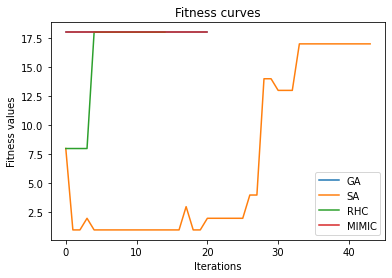

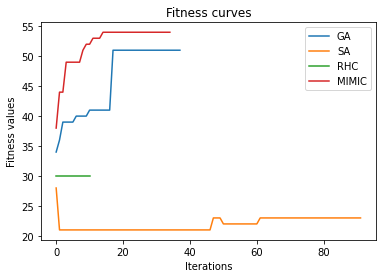

In [ ]:
traintimes ={}
max_values = {}
function_evals={}

len_prob = 60
fitness_4peaks = mlrh.FourPeaks(t_pct=0.1)
problem_4peaks = mlrh.DiscreteOpt(length = len_prob, fitness_fn = fitness_4peaks, maximize = True)
schedule = mlrh.ExpDecay()

def run_all(problem, fitness, justcurves,  traintimes ,max_values, function_evals, args):
    schedule = args['schedule']
    init_state = args['init_state']
    
    curvega, traintimes, max_values, function_evals = ga_mine(problem=problem, fitness=fitness, mutation=0.001, pop=100,
                                            traintimes=traintimes ,max_values=max_values, function_evals=function_evals,
                                                             minimum_elites=10)

    curvesa, traintimes, max_values, function_evals = sim_ann(problem=problem, fitness=fitness, schedule=schedule,
                                  init_state=init_state, traintimes=traintimes ,max_values=max_values, function_evals=function_evals)  

    curverhc, traintimes, max_values, function_evals = rhc_mine(problem=problem, fitness=fitness, rs=10, 
                                                                init_state=init_state,
                                         traintimes=traintimes ,max_values=max_values, function_evals=function_evals)  

    curvemimic, traintimes, max_values, function_evals = mimic_mine(problem=problem, fitness=fitness,  keep_pct=0.2, pop=200, 
                                     traintimes=traintimes ,max_values=max_values, function_evals=function_evals)  
    if justcurves:
        figure, axis = plt.subplots(1, 1)
        plt.plot(curvega[:,0], label='GA')
        plt.plot(curvesa[:,0], label='SA')
        plt.plot(curverhc[:,0], label='RHC')
        plt.plot(curvemimic[:,0], label='MIMIC')
        plt.legend()
        plt.title('Fitness curves')
        plt.xlabel('Iterations')
        plt.ylabel('Fitness values')
        plt.show()
        
    return traintimes, max_values, function_evals

len_prob = [10, 30, 50, 70, 80]

tts = []
mvs = []
fes = []

for l in len_prob:
    fitness_4peaks = mlrh.FourPeaks(t_pct=0.1)
    problem_4peaks = mlrh.DiscreteOpt(length = l, fitness_fn = fitness_4peaks, maximize = True)

    
    args={}
    args['schedule'] = schedule
    args['init_state'] = [0] + [1] +[0]*(l - 2)

    tt, mv, fe = run_all(problem_4peaks, fitness_4peaks, True, traintimes ,max_values, function_evals, args)
    tts.append(copy.deepcopy(tt))
    mvs.append(copy.deepcopy(mv))
    fes.append(copy.deepcopy(fe))
      

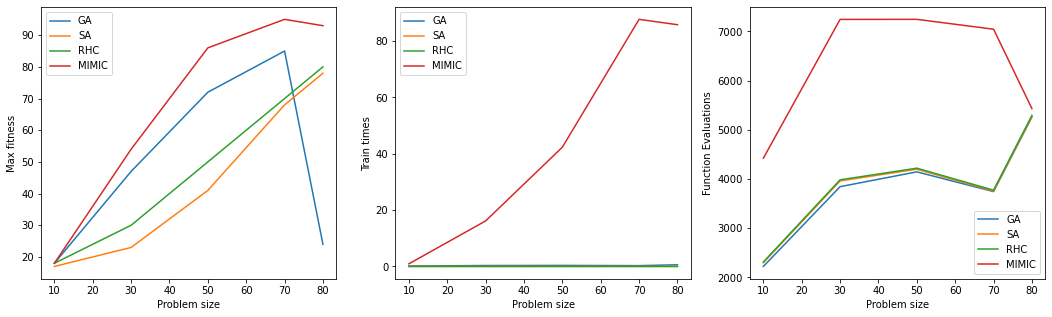

In [110]:
  
plot_maxs = True
if plot_maxs:
    ga_tts = [v for l in tts for k,v in l.items() if k == 'ga' ]
    sa_tts = [v for l in tts for k,v in l.items() if k == 'sa' ]
    rhc_tts = [v for l in tts for k,v in l.items() if k == 'rhc' ]
    mimic_tts = [v for l in tts for k,v in l.items() if k == 'mimic' ]
    
    ga_mvs = [v for l in mvs for k,v in l.items() if k == 'ga' ]
    sa_mvs = [v for l in mvs for k,v in l.items() if k == 'sa' ]
    rhc_mvs = [v for l in mvs for k,v in l.items() if k == 'rhc' ]
    mimic_mvs = [v for l in mvs for k,v in l.items() if k == 'mimic' ]
    
    ga_fes = [v for l in fes for k,v in l.items() if k == 'ga' ]
    sa_fes = [v for l in fes for k,v in l.items() if k == 'sa' ]
    rhc_fes = [v for l in fes for k,v in l.items() if k == 'rhc' ]
    mimic_fes = [v for l in fes for k,v in l.items() if k == 'mimic' ]
    
    figure, axis = plt.subplots(1, 3, figsize=(18, 5))
    axis[0].plot(len_prob, ga_mvs, label='GA')
    axis[0].plot(len_prob, sa_mvs, label='SA')
    axis[0].plot(len_prob, rhc_mvs, label='RHC')
    axis[0].plot(len_prob, mimic_mvs, label='MIMIC')
    
    axis[0].set_xlabel('Problem size')
    axis[0].set_ylabel('Max fitness')
    axis[0].legend()
    
    axis[1].plot(len_prob, ga_tts, label='GA')
    axis[1].plot(len_prob, sa_tts, label='SA')
    axis[1].plot(len_prob, rhc_tts, label='RHC')
    axis[1].plot(len_prob, mimic_tts, label='MIMIC')
    axis[1].set_xlabel('Problem size')
    axis[1].set_ylabel('Train times')
    axis[1].legend()

    
    axis[2].plot(len_prob, ga_fes, label='GA')
    axis[2].plot(len_prob, sa_fes, label='SA')
    axis[2].plot(len_prob, rhc_fes, label='RHC')
    axis[2].plot(len_prob, mimic_fes, label='MIMIC')
    axis[2].set_xlabel('Problem size')
    axis[2].set_ylabel('Function Evaluations')
    axis[2].legend()
    plt.show()   

#### OneMax Problem
I expect SA and RHC to perform better because there are no local minima/maxima. it should be easier to find the maxima

In [ ]:
len_prob = 5
fitness_1max = mlrh.OneMax()
problem_1max = mlrh.DiscreteOpt(length = len_prob, fitness_fn = fitness_1max, maximize = True)

schedule = mlrh.ExpDecay()

In [ ]:
traintimes ={}
max_values = {}
function_evals={}

def run_all(problem, fitness, justcurves,  traintimes ,max_values, function_evals, args):
    schedule = args['schedule']
    init_state = args['init_state']
    
    curvega, traintimes, max_values, function_evals = ga_mine(problem=problem, fitness=fitness, mutation=0.001, pop=100,
                                            traintimes=traintimes ,max_values=max_values, function_evals=function_evals)   

    curvesa, traintimes, max_values, function_evals = sim_ann(problem=problem, fitness=fitness, schedule=schedule,
                                  init_state=init_state, traintimes=traintimes ,max_values=max_values, function_evals=function_evals)  

    curverhc, traintimes, max_values, function_evals = rhc_mine(problem=problem, fitness=fitness, rs=10, 
                                                                init_state=init_state,
                                         traintimes=traintimes ,max_values=max_values, function_evals=function_evals)  

    curvemimic, traintimes, max_values, function_evals = mimic_mine(problem=problem, fitness=fitness,  keep_pct=0.1, pop=100, 
                                     traintimes=traintimes ,max_values=max_values, function_evals=function_evals)  
    if justcurves:
        figure, axis = plt.subplots(1, 1)
        plt.plot(curvega[:,0], label='GA')
        plt.plot(curvesa[:,0], label='SA')
        plt.plot(curverhc[:,0], label='RHC')
        plt.plot(curvemimic[:,0], label='MIMIC')
        plt.legend()
        plt.title('Fitness curves')
        plt.xlabel('Iterations')
        plt.ylabel('Fitness values')
        plt.show()
        
    return traintimes, max_values, function_evals

len_prob = [10]

tts = []
mvs = []
fes = []

for l in len_prob:
    fitness_1max = mlrh.OneMax()
    problem_1max = mlrh.DiscreteOpt(length = l, fitness_fn = fitness_1max, maximize = True)

    
    args={}
    args['schedule'] = schedule
    args['init_state'] = [0] + [1] +[0]*(l - 2)

    tt, mv, fe = run_all(problem_4peaks, fitness_4peaks, False, traintimes ,max_values, function_evals, args)
    tts.append(copy.deepcopy(tt))
    mvs.append(copy.deepcopy(mv))
    fes.append(copy.deepcopy(fe))
    
plot_maxs = False
if plot_maxs:
    ga_tts = [v for l in tts for k,v in l.items() if k == 'ga' ]
    sa_tts = [v for l in tts for k,v in l.items() if k == 'sa' ]
    rhc_tts = [v for l in tts for k,v in l.items() if k == 'rhc' ]
    mimic_tts = [v for l in tts for k,v in l.items() if k == 'mimic' ]
    
    ga_mvs = [v for l in mvs for k,v in l.items() if k == 'ga' ]
    sa_mvs = [v for l in mvs for k,v in l.items() if k == 'sa' ]
    rhc_mvs = [v for l in mvs for k,v in l.items() if k == 'rhc' ]
    mimic_mvs = [v for l in mvs for k,v in l.items() if k == 'mimic' ]
    
    ga_fes = [v for l in fes for k,v in l.items() if k == 'ga' ]
    sa_fes = [v for l in fes for k,v in l.items() if k == 'sa' ]
    rhc_fes = [v for l in fes for k,v in l.items() if k == 'rhc' ]
    mimic_fes = [v for l in fes for k,v in l.items() if k == 'mimic' ]
    
    figure, axis = plt.subplots(1, 3, figsize=(18, 5))
    axis[0].plot(len_prob, ga_mvs, label='GA')
    axis[0].plot(len_prob, sa_mvs, label='SA')
    axis[0].plot(len_prob, rhc_mvs, label='RHC')
    axis[0].plot(len_prob, mimic_mvs, label='MIMIC')
    
    axis[0].set_xlabel('Problem size')
    axis[0].set_ylabel('Max fitness')
    axis[0].legend()
    
    axis[1].plot(len_prob, ga_tts, label='GA')
    axis[1].plot(len_prob, sa_tts, label='SA')
    axis[1].plot(len_prob, rhc_tts, label='RHC')
    axis[1].plot(len_prob, mimic_tts, label='MIMIC')
    axis[1].set_xlabel('Problem size')
    axis[1].set_ylabel('Train times')
    axis[1].legend()

    
    axis[2].plot(len_prob, ga_fes, label='GA')
    axis[2].plot(len_prob, sa_fes, label='SA')
    axis[2].plot(len_prob, rhc_fes, label='RHC')
    axis[2].plot(len_prob, mimic_fes, label='MIMIC')
    axis[2].set_xlabel('Problem size')
    axis[2].set_ylabel('Function Evaluations')
    axis[2].legend()
    plt.show()       